## Object Detection & Image Classification with Faster R-CNN

**Cognitive Computing and Artificial Intelligence, 2022/2023**

Arena Gabriele,  Corsaro Miriana, Ventimiglia Andrea

## Settings

In [ ]:
# Define root directory from Google Drive
from google.colab import drive
drive.mount("/content/drive")
root_dir = "/content/drive/My Drive/Colab Notebooks/CCAI Project/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
from glob import glob
from random import shuffle
import os
import matplotlib.pyplot as plt

import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader

In [ ]:
# Setup device
dev = torch.device("cuda" if torch.cuda.is_available()else "cpu")
print(dev)

cuda


## Get bounding boxes

In [ ]:
# Ottenimento dati dal train.csv
import csv

train_data = []

with open(os.path.join(root_dir, "train.csv"), 'r') as train_csv:

  reader = csv.reader(train_csv)
  next(reader)

  for row in reader:
    x1 = float(row[1])
    y1 = float(row[2])
    x2 = float(row[3])
    y2 = float(row[4])

    train_data.append([x1,y1,x2,y2])

boxes_train_data = torch.tensor(train_data)

print(boxes_train_data.shape)

torch.Size([1600, 4])


In [ ]:
# Ottenimento dati dal test.csv
test_data = []

with open(os.path.join(root_dir, "test.csv"), 'r') as test_csv:
  reader = csv.reader(test_csv)
  next(reader)

  for row in reader:
    x1 = float(row[1])
    y1 = float(row[2])
    x2 = float(row[3])
    y2 = float(row[4])

    test_data.append([x1,y1,x2,y2])

boxes_test_data = torch.tensor(test_data)

print(boxes_test_data.shape)

torch.Size([800, 4])


## Get Dataset

In [ ]:
from PIL import Image
from torch.utils.data import Dataset
import natsort
import torchvision.transforms as T

class TestDataSet(Dataset):
    def __init__(self, main_dir, transform = None):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.main_dir, self.total_imgs[idx])
        img_name = self.total_imgs[idx]

        img = Image.open(img_path).convert("RGB")

        if self.transform:
          img = self.transform(img)

        return img_name, img

In [ ]:
class ObjectDataset(Dataset):
  def __init__(self, train_dataset, boxes_train_data, transforms):
    super().__init__()

    self.train_dataset = train_dataset
    self.boxes_train_data = boxes_train_data
    self.transforms = transforms

  def __len__(self):
    return len(self.train_dataset)

  def __getitem__(self, idx):
    img, label = self.train_dataset[idx]
    boxes = self.boxes_train_data[idx]

    if self.transforms:
      img, boxes, label = self.transforms(img, boxes, label)

    target = {'boxes' : boxes.unsqueeze(0).to(dev), 'labels' : (torch.Tensor([label]).to(dev)).type(torch.int64)}

    return img, target

In [ ]:
# Get Dataset
train_images_dataset = ImageFolder(os.path.join(root_dir, "train"), T.ToTensor())

In [ ]:
imgs = [item[0] for item in train_images_dataset] # item[0] and item[1] are image and its label
imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r,std_g,std_b)

In [ ]:
mean_r, mean_g, mean_b = 0.6415031, 0.6172485, 0.58973944
std_r,std_g,std_b = 0.20120575, 0.21529604, 0.23332374

In [ ]:
# Not used in final version

normalization = T.Normalize(mean=(mean_r,mean_g,mean_b),
                            std=(std_r,std_g,std_b))

In [ ]:
import torchvision.transforms.v2 as transforms

transf = transforms.Compose([
    transforms.ColorJitter(contrast=0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor()
])

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [ ]:
train_dataset = ObjectDataset(train_images_dataset, boxes_train_data, transf)
test_dataset = TestDataSet(root_dir + '/test', transform = T.ToTensor())

In [ ]:
img, target = train_dataset[0]

In [ ]:
import random

def show():
    import matplotlib.pyplot as plt
    import PIL.Image

    from torchvision.transforms.v2 import functional as F
    from torchvision.utils import draw_bounding_boxes

    fig=plt.figure(figsize=(30,10))
    rows, columns = 1, 10
    j = 1

    for _ in range(8):
      idx = random.randint(0, len(train_dataset)-1)
      image, target = train_dataset[idx]

      fig.add_subplot(rows, columns, j)
      image = F.convert_dtype(image, torch.uint8)
      annotated_image = draw_bounding_boxes(image, target['boxes'], colors="yellow", width=3)
      plt.imshow(annotated_image.cpu().permute(1, 2, 0).numpy())
      plt.axis('off')
      j+=1

plt.show()

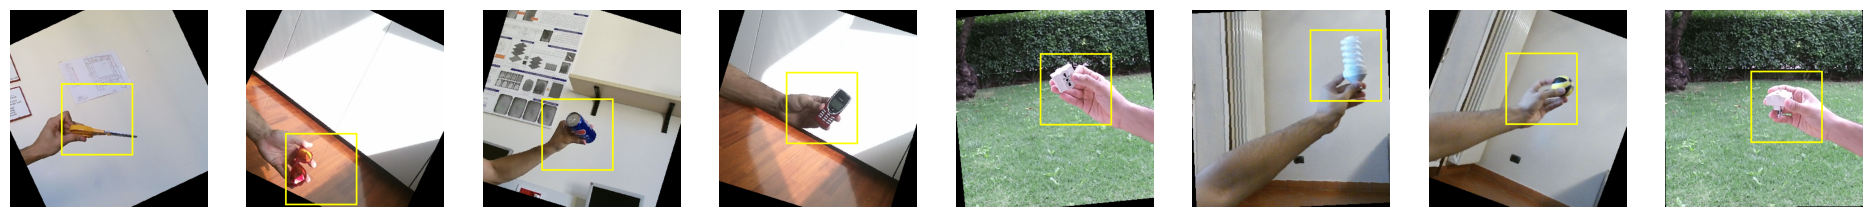

In [ ]:
show()

In [ ]:
from torch.utils.data import DataLoader

# dataloader of training set with dictionary target
def collate_fn(batch):
    return list(zip(*batch))

# Define loaders
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=0, shuffle=True, drop_last = True, collate_fn=collate_fn)

## Faster R-CNN

During training, the model expects both the input tensors and targets (list of dictionary), containing:

* boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.

* labels (Int64Tensor[N]): the class label for each ground-truth box

In [ ]:
# TRAINING
import torch.optim as optim

def train(model, epochs, dev, train_loader, lr=0.01):
    try:

        model = model.to(dev)
        model.train()

        optimizer = optim.SGD(model.parameters(), lr=lr)

        history_loss = []

        for epoch in range(epochs):
            sum_loss = 0

            for input, targets in train_loader:
                input = torch.stack(list(input), dim=0)
                input = input.to(dev)

                loss_dict = model(input, targets)

                # The loss is composed of several parts:
                # - class loss,
                # - bounding box loss
                # We sum all of these parts together to get the total loss as a single number
                loss = sum(loss for loss in loss_dict.values())
                sum_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            epoch_loss = sum_loss/len(train_loader)
            history_loss.append(epoch_loss)

            print(f"Epoch {epoch+1}: TrL={epoch_loss:.4f}")

            if epoch % 5 == 0:
              torch.save(model.state_dict(), f'model_{epoch}.pth')

    except KeyboardInterrupt:
        print("Interrupted")

    finally:
        plt.title("Loss")
        plt.plot(history_loss, label='train')
        plt.legend()
        plt.show()

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn as fasterRCNN

fasterrcnn = fasterRCNN(num_classes = len(train_images_dataset.classes))

In [ ]:
train(fasterrcnn, 20, dev, train_loader, 0.01)

In [ ]:
# TEST

fasterrcnn.eval()

predicted_classes = []
for idx, (img_name, img) in enumerate(test_dataset):
  with torch.no_grad():
    output = fasterrcnn(img.unsqueeze(0).to(dev))
    for index,prediction in enumerate(output):
      if len(prediction.get("scores")) >= 1:
        predicted_classes.append([img_name,output[index]['labels'][0].item()])
      else:
        predicted_classes.append([img_name,0])

In [ ]:
import csv

# Save results into submission.csv

header = ['image','class']

print(predicted_classes)
with open('submission.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    writer.writerow(header)
    writer.writerows(predicted_classes)

In [ ]:
classes_name = {0: 'plug', 1 : 'cellphone', 2 :'scissor', 3 : 'bulb', 4: 'drink', 5: 'glasses', 6: 'ball', 7: 'cup'}

In [ ]:
import random

def show_inference(test_dataset, predicted_classes):
  fig=plt.figure(figsize=(20,10))
  rows, columns = 5, 10
  j=1

  for _ in range(50):
    idx = random.randint(0, len(test_dataset)-1)

    # Normalize and show image
    fig.add_subplot(rows, columns, j)
    img_name, input = test_dataset[idx]
    input_show = (input - input.min())/(input.max() - input.min())
    plt.imshow(input_show.permute(1,2,0).numpy())
    plt.axis('off')

    # Get predicted class
    pred = predicted_classes[idx][1]
    plt.title(f"{img_name}, {classes_name[pred]}")
    j+=1

  plt.show()

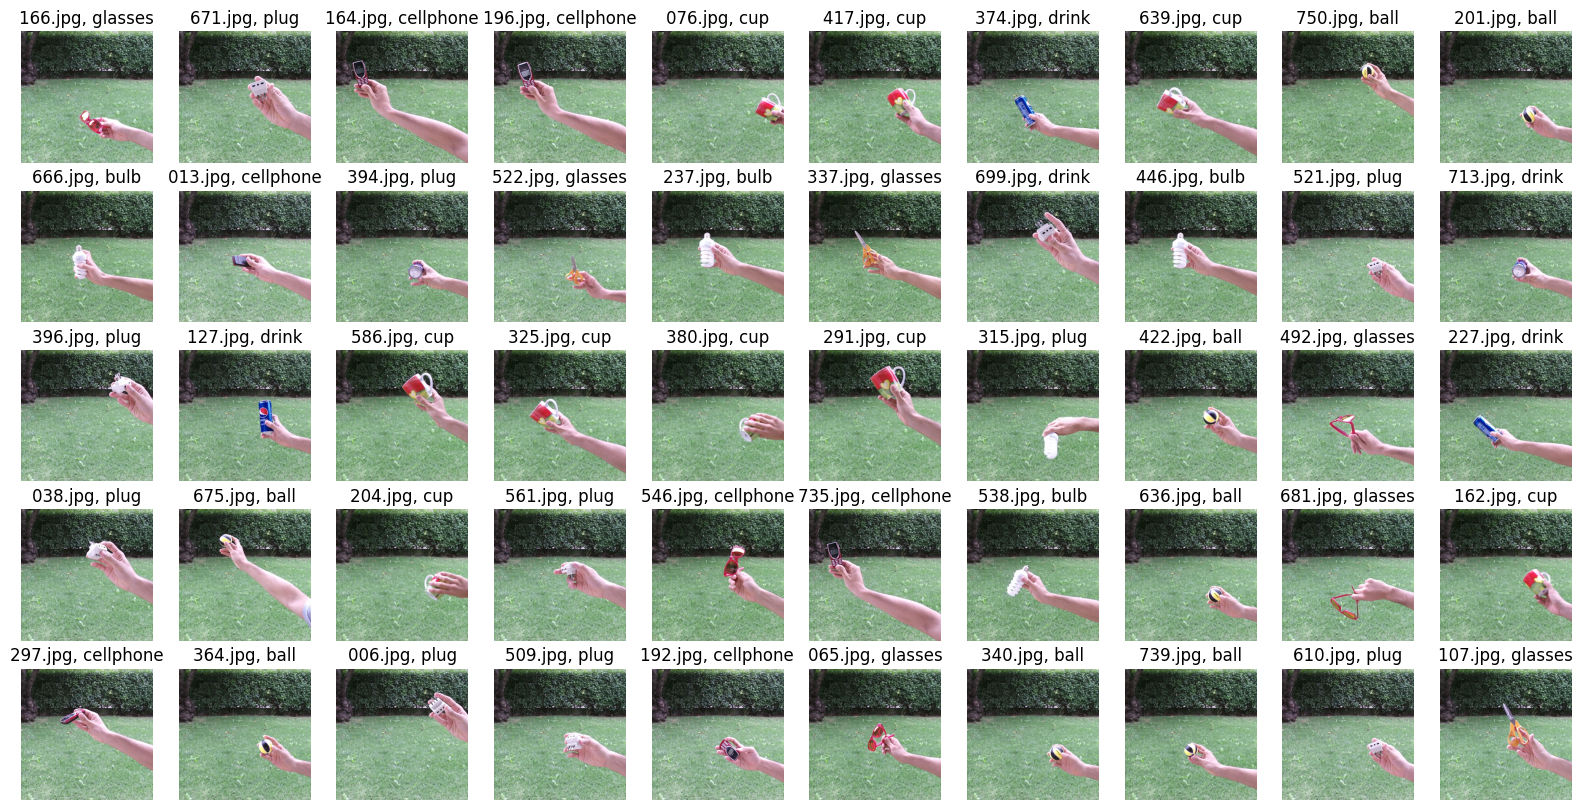

In [ ]:
show_inference(test_dataset, predicted_classes)